## Creating a function from a symbolic expression
In SymPy there is a function to create a Python function which evaluates (usually numerically) an expression. SymPy allows the user to define the signature of this function (which is convenient when working with e.g. a numerical solver in ``scipy``).

In [1]:
import sympy as sym
sym.init_printing()

We will look at an arbitrary expression $f(x, y)$:

$$
f(x, y) = 3 x^{2} + \log{\left (x^{2} + y^{2} + 1 \right )}
$$

In [2]:
x, y = sym.symbols('x y')
expr = 3*x**2 + sym.log(x**2 + y**2 + 1)
expr

One way to evaluate above expression numerically is to invoke the ``subs`` method followed by the ``evalf`` method:

In [3]:
expr.subs({x: 17, y: 42}).evalf()

However, if we need to do this repeatedly it can be quite slow:

In [4]:
%timeit expr.subs({x: 17, y: 42}).evalf()

762 µs ± 40.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


even compared to a simple lambda function:

In [5]:
import math
f = lambda x, y: 3*x**2 + math.log(x**2 + y**2 + 1)
f(17, 42)

In [6]:
%timeit f(17, 42)

2.91 µs ± 96.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


SymPy can also create a function analogous to f above. The function for doing so is called ``lambdify``:

In [7]:
g = sym.lambdify([x, y], expr, modules=['math'])
g(17, 42)

In [8]:
%timeit g(17, 42)

2.83 µs ± 26.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Note how we specified ``modules`` above: it tells ``lambdify`` to use ``math.log``, if we don't specify modules SymPy will (since v1.1) use ``numpy`` by default. This can be useful when dealing with arrays in the input:

In [9]:
import numpy as np
xarr = np.linspace(17, 18, 5)
h = sym.lambdify([x, y], expr)
out = h(xarr, 42)
out.shape

NumPy's [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) (handling of different shapes) then works as expected:

In [10]:
yarr = np.linspace(42, 43, 7).reshape((1, 7))
out2 = h(xarr.reshape((5, 1)), yarr)  # if we would try to use g() here, it would fail
out2.shape

Behind the scenes ``lambdify`` constructs a string representation of the Python code and uses Python's ``eval`` function to compile the function.

Let's now look at how we can get a specific function signature from ``lambdify``:

In [11]:
z = z1, z2, z3 = sym.symbols('z:3')
expr2 = x*y*(z1 + z2 + z3)
func2 = sym.lambdify([x, y, z], expr2)
func2(1, 2, (3, 4, 5))

## Exercise: Create a function from a symbolic expression
Plot $z(x, y) = \frac{\partial^2 f(x,y)}{\partial x \partial y}$ from above ($f(x, y)$ is available as ``expr``) as a surface plot for $-5 < x < 5, -5 < y < 5$.

In [12]:
xplot = np.outer(np.linspace(-5, 5, 100), np.ones(100))
yplot = xplot.T

In [13]:
%load_ext scipy2017codegen.exercise

*Use either the *``%exercise``* or *``%load``* magic to get the exercise / solution respecitvely*

In [14]:
# %exercise exercise_lambdify_expr.py
d2fdxdy = expr.diff(x, y)  # EXERCISE: x, y
func = sym.lambdify([x, y], d2fdxdy)  # EXERCISE: lambdify
zplot = func(xplot, yplot)

Replace **???** with the correct expression above.

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

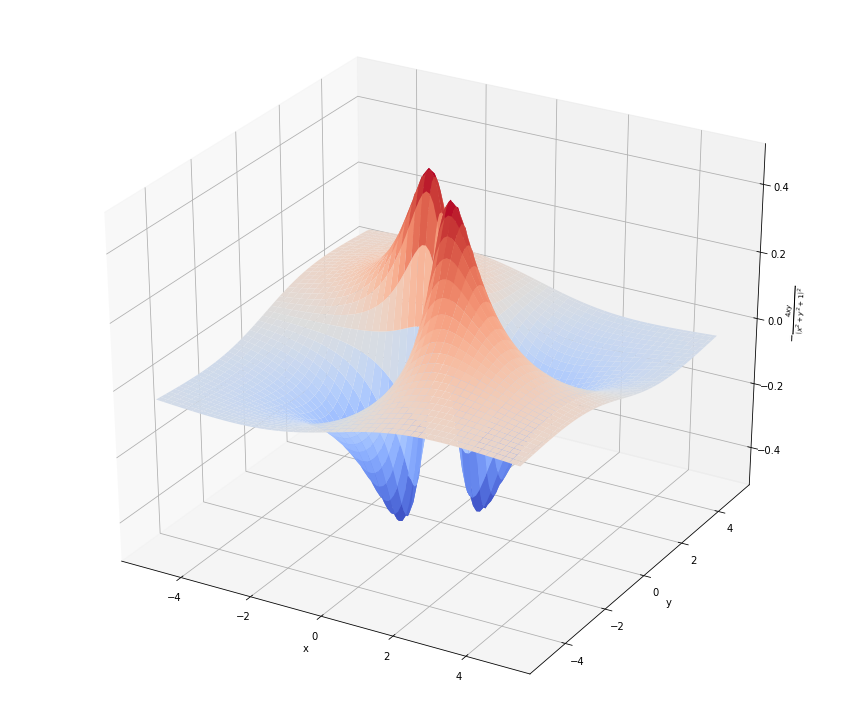

In [16]:
fig = plt.figure(figsize=(15, 13))
ax = plt.axes(projection='3d')
ax.plot_surface(xplot, yplot, zplot, cmap=plt.cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$%s$' % sym.latex(d2fdxdy))